In [28]:
from fink_utils.sso.periods import (
    estimate_synodic_period,
    estimate_sso_params,
    extract_physical_parameters,
    compute_residuals,
)  # v0.21.0 or more
import requests
import time
import io

import os

import numpy as np
import pandas as pd

import rocks

import matplotlib.pyplot as plt

import astropy.constants as const

from astropy.timeseries import LombScargleMultiband
# import seaborn as sns
# sns.set_context("poster")

In [2]:
cols = [
    "sso_number",
    "sso_name",
    "sso_class",
    "spins.1.period.value",
    "spins.2.period.value",
]

# Read BFT with rocks
bft = rocks.load_bft(columns=cols)

# Functions

In [3]:

# Speed of light in AU/day
import astropy.constants as const
c_speed = const.c.to('au/day').value


def estimate_synodic_period_ltc(
    ssnamenr: str = None,
    pdf=None,
    phyparam=None,
    flavor="SHG1G2",
    Nterms_base=1,
    Nterms_band=1,
    period_range=(0.05, 1.2),
    sb_method="auto",
    return_extra_info=False,
):
    """Estimate the synodic period of a Solar System object seen by Fink

    Parameters
    ----------
    ssnamenr: str
        SSO number (we do not resolve name yet)
    pdf: pandas DataFrame, optional
        Pandas DataFrame with Fink SSO data for one object.
        If not specified, data will be downloaded from Fink servers
        using `ssnamenr`.
    phyparam: dict, optional
        Dictionary containing physical properties (phase curve, etc.)
        of the object. If not specified, they will be recomputed
        from the data.
    flavor: str, optional
        Model flavor: SHG1G2 (default), HG1G2, HG12, or HG
    Nterms_base: int, optional
        Number of frequency terms to use for the
        base model common to all bands. Default is 1.
    Nterms_band: int, optional
        Number of frequency terms to use for the
        residuals between the base model and
        each individual band. Default is 1.
    period_range: tupe of float, optional
        (min_period, max_period) for the search, in days.
        Default is (0.05, 1.2), that is between
        1.2 hours and 28.8 hours.
    sb_method: str, optional
        Specify the single-band lomb scargle implementation to use.
        See https://docs.astropy.org/en/stable/api/astropy.timeseries.LombScargleMultiband.html#astropy.timeseries.LombScargleMultiband.autopower
        If nifty-ls is installed, one can also specify fastnifty. Although
        in this case it does not work yet for Nterms_* higher than 1.
    return_extra_info: bool, optional
        If True, returns also the fitted model, and the original
        SSO data used for the fit. Default is False.

    Returns
    -------
    best_period: float
        Best period found, in hour
    reduced_chi2: float
        Reduced chi2 (chi2 per ddof)
    model: object, optional
        If `return_extra_info`, the fitted model is returned
    pdf: pandas DataFrame, optional
        If `return_extra_info`, the original data is returned.
        Note that the extra field "residuals" contains the
        `observation - model` data, in magnitude.

    Examples
    --------
    >>> ssnamenr = 2363
    >>> P, chi2 = estimate_synodic_period(ssnamenr, flavor="SHG1G2", Nterms_base=2)
    >>> assert int(P) == 20, P

    >>> P_HG, chi2_HG = estimate_synodic_period(ssnamenr, flavor="HG", Nterms_base=2)
    >>> assert chi2 < chi2_HG, (chi2, chi2_HG)


    One can also use the nifty-ls implementation (faster and more accurate)
    # TODO: check alias between astropy and nifty-ls...
    >>> P_nifty, _ = estimate_synodic_period(ssnamenr, flavor="SHG1G2", sb_method="fastnifty")
    >>> assert np.isclose(P, 2 * P_nifty, rtol=1e-1), (P, P_nifty)

    One can also directly specify the Pandas dataframe with Fink data:
    # TODO: check alias between astropy and nifty-ls...
    >>> r = requests.post("https://fink-portal.org/api/v1/sso", json={"n_or_d": ssnamenr, "withEphem": True, "output-format": "json"})
    >>> pdf = pd.read_json(io.BytesIO(r.content))
    >>> P_from_pdf, _ = estimate_synodic_period(pdf=pdf, flavor="SHG1G2")
    >>> assert np.isclose(P, 2 * P_from_pdf, rtol=1e-1), (P, P_from_pdf)
    """
    if pdf is None:
        if ssnamenr is not None:
            # TODO: use quaero
            r = requests.post(
                "https://fink-portal.org/api/v1/sso",
                json={"n_or_d": ssnamenr, "withEphem": True, "output-format": "json"},
            )
        else:
            _LOG.error("You need to specify either `ssnamenr` or `pdf`.")

        pdf = pd.read_json(io.BytesIO(r.content))

    if phyparam is None:
        # get the physical parameters with the latest data
        phyparam = extract_physical_parameters(pdf, flavor)

    # Compute the residuals (obs - model)
    residuals = compute_residuals(pdf, flavor, phyparam)

    pdf['jd_ltc'] = pdf['i:jd'] - pdf['Dobs']/c_speed

    model = LombScargleMultiband(
        pdf["jd_ltc"],
        residuals,
        pdf["i:fid"],
        pdf["i:sigmapsf"],
        nterms_base=Nterms_base,
        nterms_band=Nterms_band,
    )

    frequency, power = model.autopower(
        method="fast",
        sb_method=sb_method,
        minimum_frequency=1 / period_range[1],
        maximum_frequency=1 / period_range[0],
    )
    freq_maxpower = frequency[np.argmax(power)]
    best_period = 1 / freq_maxpower

    out = model.model(pdf["i:jd"].to_numpy(), freq_maxpower)
    prediction = np.zeros_like(residuals)
    for index, filt in enumerate(pdf["i:fid"].unique()):
        if filt == 3:
            continue
        cond = pdf["i:fid"] == filt
        prediction[cond] = out[index][cond]

    chi2 = np.sum(((residuals - prediction) / pdf["i:sigmapsf"].to_numpy()) ** 2)
    reduced_chi2 = chi2 / len(residuals - 1)

    if return_extra_info:
        pdf["residuals"] = residuals
        return best_period * 24, reduced_chi2, frequency, power, model, pdf
    else:
        return best_period * 24, reduced_chi2


## Period estimation

In [104]:
flavor = "SHG1G2"
ssnamenr = 105140 # Find the real period!
ssnamenr = 136108 # KBO...
ssnamenr = 186153 # High frequency observation
# ssnamenr = 223 # Example article 
# ssnamenr = 9799 # JTO lotta obs
ssnamenr = 25916 # NEA
ssnamenr = 142 # Polana
ssnamenr = 2200 # IMB off nominal - YES FIND IT!
ssnamenr = 2540 # Idem slow (LC...) - not found
ssnamenr = 1928 # Idem fast (LC...)
ssnamenr= 5518 # LCI super slow - not found 
ssnamenr= 683 # LCI - nope
ssnamenr = 1234	# LCI


nam_num = rocks.identify(ssnamenr)
sc = rocks.Rock(nam_num[0])

try:
    ref_period = sc.parameters.physical.spin[0].period.value
except:
    ref_period = np.nan

In [105]:
period_range = (1 / 24, 7)  # 1hour to 7 days

t0 = time.time()
period, chi2red, frequency, power, model, pdf = estimate_synodic_period(
    ssnamenr,
    flavor=flavor,
    Nterms_base=1,
    period_range=period_range,
    return_extra_info=True,
)

print(
    "[{:.2f} seconds] model={}: period={:.2f} hours (chi2red={:.2f}) -- BFT: period={:.2f} hours".format(
        time.time() - t0,
        flavor,
        period,
        chi2red,
        ref_period,
    )
)

[13.41 seconds] model=SHG1G2: period=2.44 hours (chi2red=4.81) -- BFT: period=5.42 hours


In [106]:
period_range = (1 / 24, 7)  # 1hour to 7 days

t0 = time.time()
period_ltc, chi2red_ltc, frequency_ltc, power_ltc, model_ltc, pdf_ltc = (
    estimate_synodic_period_ltc(
        ssnamenr,
        flavor=flavor,
        Nterms_base=1,
        period_range=period_range,
        return_extra_info=True,
    )
)

print(
    "[{:.2f} seconds] model={}: period={:.2f} hours (chi2red={:.2f}) -- BFT: period={:.2f} hours".format(
        time.time() - t0,
        flavor,
        period_ltc,
        chi2red_ltc,
        ref_period,
    )
)

[13.31 seconds] model=SHG1G2: period=2.44 hours (chi2red=5.89) -- BFT: period=5.42 hours


## Periodogram

In [107]:
def convert_to_float(frac_str):
    try:
        return float(frac_str)
    except ValueError:
        num, denom = frac_str.split('/')
        try:
            leading, num = num.split(' ')
            whole = float(leading)
        except ValueError:
            whole = 0
        frac = float(num) / float(denom)
        return whole - frac if whole < 0 else whole + frac

In [108]:
max_ltc = np.max( (pdf_ltc['i:jd'] - pdf_ltc['jd_ltc'])) 
min_ltc = np.min( (pdf_ltc['i:jd'] - pdf_ltc['jd_ltc'])) 
range_ltc = max_ltc - min_ltc
max_ltc, min_ltc, range_ltc

(0.022801906801760197, 0.010263446718454361, 0.012538460083305836)

## Residuals

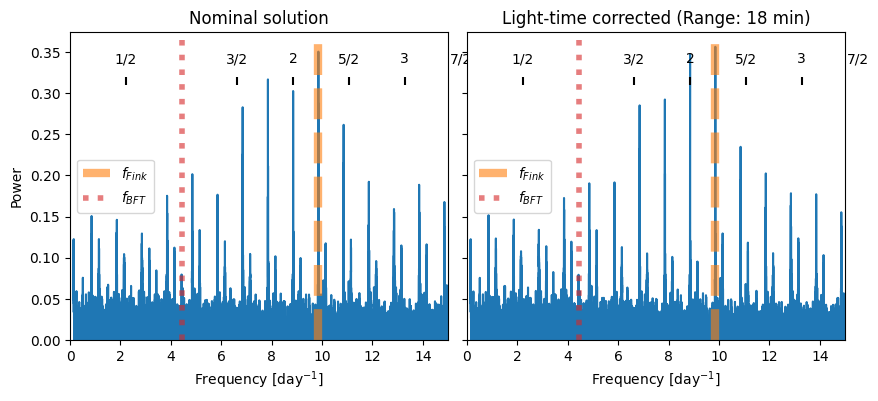

In [109]:
period_bft = ref_period

fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharey=True, sharex=True, gridspec_kw={"wspace": 0.05})


ax[0].set_title("Nominal solution")
ax[0].plot(frequency, power)
ax[0].axvline(1 / period * 24, ls="--", lw=6, color="C1", alpha=0.6, label=r"$f_{Fink}$")
ax[0].axvline(1 / period_bft * 24, ls=":", lw=4, color="C3", alpha=0.6, label=r"$f_{BFT}$")

ax[1].set_title(f"Light-time corrected (Range: {range_ltc*24*60:.0f} min)")
ax[1].plot(frequency_ltc, power_ltc)
ax[1].axvline(1 / period_ltc * 24, ls="--", lw=6, color="C1", alpha=0.6, label=r"$f_{Fink}$")
ax[1].axvline(1 / period_bft * 24, ls=":", lw=4, color="C3", alpha=0.6, label=r"$f_{BFT}$")

aliases = ['1/2', '3/2','2','5/2','3','7/2']
aliases_values = [1 / period_bft * 24 * convert_to_float(a) for a in aliases]
for a in ax:
    a.scatter( aliases_values, np.full( len(aliases), np.max(power)*0.9), marker='|', color="black", zorder=2)
    for i, alias in enumerate(aliases):
        a.text( aliases_values[i], np.max(power)*0.95, alias, ha='center', va='bottom' )

for a in ax:
    a.set_xlim(0, 15)
    a.set_xlabel(r"Frequency [day$^{-1}$]")
    a.legend(loc='best')
    a.set_ylim(bottom=0)

ax[0].set_ylabel("Power")

root = f"{nam_num[1]}_{nam_num[0]}".replace(" ", "_")
fig.savefig(
    os.path.join("..", "..", "gfx", "ssHG1G2", f"{root}_LTC.png"),
    dpi=180,
    facecolor="white",
)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5), sharey=True, gridspec_kw={"wspace": 0.03})

for filtnum in pdf["i:fid"].unique():
    cond = pdf["i:fid"] == filtnum
    ax[0].plot(pdf["i:jd"][cond], pdf["residuals"][cond], ls="", marker=".")
    
    ax[1].plot(pdf_ltc["i:jd"][cond], pdf_ltc["residuals"][cond], ls="", marker=".")

ax[0].axhline(0, ls="--", color="grey")
ax[1].axhline(0, ls="--", color="grey")

max_res = 0.4
ax[0].set_ylim(-max_res, max_res)
ax[0].set_xlabel("JD (day)")
# ax[1].set_xlabel("Phase angle (deg)")
ax[0].set_ylabel("Residual (mag)")

## Folding

In [ ]:
fig = plt.figure(figsize=(12, 8))

tfit = np.linspace(0, period / 24, 100)
magfit = model.model(tfit, 1 / period * 24)
colors = ["C0", "C1"]
dicband = {1: "g", 2: "r"}
for index, (color, filtnum) in enumerate(zip(colors, pdf["i:fid"].unique())):
    cond = pdf["i:fid"] == filtnum
    phase = pdf["i:jd"][cond] % (period / 24)
    plt.errorbar(
        phase * 24,
        pdf["residuals"][cond],
        pdf["i:sigmapsf"][cond],
        ls="",
        marker=".",
        alpha=0.5,
        color=color,
        label="{} band".format(dicband[filtnum]),
    )
    plt.plot(tfit * 24, magfit[index], ls="-", marker="", color=color)
plt.axhline(0, ls="--", color="grey")
# plt.ylim(-0.7, 0.7)
plt.title("sso={} Period={:.2f} hours (chi2: {:.2f})".format(ssnamenr, period, chi2red))
plt.xlabel("Phase (hour)")
plt.ylabel("Residual (mag)")
plt.legend()